<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#5d3a8e; font-size:40px'> Topic Modeling For NBC News Digital Social Media Content</h1>
</div>

This is hacky way to try to understand the distribution of top-performing content on Facebook over the past 12 months. We'll be using Latent Dirichlet Allocation(LDA) for topic modeling along with the Python Gensim package. To make this worthwhile, we'll start cleaning up the text, breaking the posts into bigrams, and then determining the optimal number of topics.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Download nltk stopwords and spacy model</h2>
</div>

Stopwords from NLTK and spacy’s en model for text pre-processing. Spacy model for lemmatization.

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
#python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a206679878/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Import Packages</h2>
</div>

The core packages are `re`, `gensim`, `spacy` and `pyLDAvis`. `matplotlib`,`numpy` and `pandas` for data handling and visualization.

In [2]:
import sys
!{sys.executable} -m pip install spacy

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/a206679878/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Why LDA?</h2>
</div>

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

A topic is a collection of dominant keywords that are typical representatives. 

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Prepare Stopwords</h2>
</div>


Importing list in `stop_words`.

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['www', 'http://'])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Import Facebook Data</h2>
</div>

We'll be using public posts from top publishers for a 12-month period. Using CrowdTangle's historic reporting, we'll download the full post data and upload a local copy for our analysis.

Import using `pandas.read_csv`.

In [5]:
# Import Dataset
df = pd.read_csv('/Users/a206679878/Documents/Untitled Folder/postings.csv')
df.head()

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Sponsor Category,Overperforming Score (weighted — Likes 1x Shares 3x Comments 2x )
0,The Hill,TheHill,7533944086,NEWS_SITE,US,The Hill is the premier source for policy and ...,2008-01-10 18:20:58,1464754,1562141,2021-07-06 16:45:20 EDT,...,Former President Trump considered issuing a pa...,http://hill.cm/AY9Rs6r,https://thehill.com/homenews/media/561735-trum...,NaN,Trump discussed pardoning Ghislaine Maxwell: book,"Wolff has written two other books about Trump,...",NaN,NaN,NaN,8.57
1,MSNBC,msnbc,273864989376427,MEDIA_NEWS_COMPANY,US,The destination for in-depth analysis of daily...,2012-05-14 16:26:44,2479926,2586695,2021-07-06 16:43:11 EDT,...,The Vice President’s life was threatened. Cops...,https://on.msnbc.com/3jM4ivl,https://www.msnbc.com/ali-velshi/watch/velshi-...,NaN,Velshi: Covering up the insurrection is the Bi...,We are witnessing an active cover-up on Capito...,NaN,NaN,NaN,4.07
2,MSNBC,msnbc,273864989376427,MEDIA_NEWS_COMPANY,US,The destination for in-depth analysis of daily...,2012-05-14 16:26:44,2479926,2586695,2021-07-06 16:38:31 EDT,...,LATEST: Tropical Storm Elsa as of 3:30pm ET. H...,https://www.facebook.com/msnbc/videos/30595231...,NaN,NaN,NBC News Meteorologist Bill Karins on Tropical...,NaN,NaN,NaN,NaN,-6.83
3,NBC News,NBCNews,155869377766434,BROADCASTING_MEDIA_PRODUCTION,US,A leading source of global news and informatio...,2010-09-30 19:35:28,10166610,10717941,2021-07-06 16:33:05 EDT,...,LATEST: Elsa could be a hurricane when it hits...,https://nbcnews.to/2V38lcn,https://www.nbcnews.com/news/weather/elsa-fore...,NaN,Elsa intensifies as it turns toward Florida co...,"Hurricane-force winds, tornadoes and up to 8 i...",NaN,NaN,NaN,1.92
4,Washington Post,washingtonpost,6250307292,BROADCASTING_MEDIA_PRODUCTION,US,Our award-winning journalists have covered Was...,2007-11-07 18:26:05,6622347,7005382,2021-07-06 16:30:28 EDT,...,"“I’m the king of the tax code,” said Trump, wh...",https://www.washingtonpost.com/politics/2021/0...,NaN,NaN,Analysis | How Trump’s claims to being ‘the ki...,"""I’m the king of the tax code,"" said Trump, wh...",NaN,NaN,NaN,3.24


In [6]:
print(df.shape)

(185647, 40)


For our text analysis, we'll need the "Description" column formatted as a string. Once that text is a string, we can start to break it up into its components.

In [7]:
df['Link Text']= df['Link Text'].map(str)

In [8]:
df.rename(columns = {"Link Text": "text"}, inplace=True)
print(df.columns)

Index(['Page Name', 'User Name', 'Facebook Id', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'Likes at Posting', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Is Video Owner?', 'Post Views',
       'Total Views', 'Total Views For All Crossposts', 'Video Length', 'URL',
       'Message', 'Link', 'Final Link', 'Image Text', 'text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Sponsor Category',
       'Overperforming Score (weighted  —  Likes 1x Shares 3x Comments 2x )'],
      dtype='object')


In [9]:
datatypes = df.dtypes
  
# Print the data types
# of each column
datatypes

Page Name                                                               object
User Name                                                               object
Facebook Id                                                              int64
Page Category                                                           object
Page Admin Top Country                                                  object
Page Description                                                        object
Page Created                                                            object
Likes at Posting                                                         int64
Followers at Posting                                                     int64
Post Created                                                            object
Post Created Date                                                       object
Post Created Time                                                       object
Type                                                

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> The Best of the Best</h2>
</div>

Now, we only want the best posts, so we will filter our results for posts only above a threshold. We'll go with all posts above 3000 likes, a typical engagement rate.

In [10]:
df_2 = df[df["Likes"] > 3000.0]

df_2

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,...,Message,Link,Final Link,Image Text,text,Description,Sponsor Id,Sponsor Name,Sponsor Category,Overperforming Score (weighted — Likes 1x Shares 3x Comments 2x )
64,The Hill,TheHill,7533944086,NEWS_SITE,US,The Hill is the premier source for policy and ...,2008-01-10 18:20:58,1464754,1562141,2021-07-06 14:00:10 EDT,...,A New Jersey man was seen in a now-viral video...,http://hill.cm/hJGUF3Y,https://thehill.com/blogs/blog-briefing-room/n...,NaN,WATCH: 100 protesters show up at home of man w...,"Mathews, during a phone interview with the Inq...",NaN,NaN,NaN,16.19
77,The Hill,TheHill,7533944086,NEWS_SITE,US,The Hill is the premier source for policy and ...,2008-01-10 18:20:58,1464754,1562141,2021-07-06 13:30:05 EDT,...,Asked in a new interview if he suspected that ...,http://hill.cm/xT55zWD,https://thehill.com/homenews/house/561672-kinz...,NaN,Kinzinger says he suspects some lawmakers knew...,"""...the whole reason I brought my gun and kept...",NaN,NaN,NaN,12.75
224,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34564937,38372380,2021-07-06 07:11:45 EDT,...,A Republican official from a key Arizona count...,https://cnn.it/3AvEcTt,https://www.cnn.com/2021/07/05/politics/clint-...,NaN,Maricopa County official on rejecting Trump al...,NaN,NaN,NaN,NaN,4.49
232,Washington Post,washingtonpost,6250307292,BROADCASTING_MEDIA_PRODUCTION,US,Our award-winning journalists have covered Was...,2007-11-07 18:26:05,6622347,7005382,2021-07-06 06:40:46 EDT,...,A man police say yelled racist slurs in front ...,https://www.washingtonpost.com/nation/2021/07/...,NaN,NaN,A man who went on a racist rant gave out his a...,The New Jersey man was later arrested as prote...,NaN,NaN,NaN,13.15
292,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34564937,38372380,2021-07-06 01:31:07 EDT,...,San Francisco's lavish Millennium Tower opened...,https://cnn.it/2V65Vtv,https://www.cnn.com/2021/07/05/us/san-francisc...,NaN,Surfside catastrophe raises concerns about San...,NaN,NaN,NaN,NaN,5.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185625,Washington Post,washingtonpost,6250307292,BROADCASTING_MEDIA_PRODUCTION,US,Our award-winning journalists have covered Was...,2007-11-07 18:26:05,6465204,6908872,2020-07-06 17:40:54 EDT,...,The book will be published on July 14 because ...,https://www.washingtonpost.com/politics/tell-a...,NaN,NaN,Tell-all book by President Trump’s niece to be...,Mary Trump’s book said to show “how Donald acq...,NaN,NaN,NaN,10.70
185629,MSNBC,msnbc,273864989376427,MEDIA_NEWS_COMPANY,US,The destination for in-depth analysis of daily...,2012-05-14 16:26:44,2374006,2504567,2020-07-06 17:31:14 EDT,...,Sen. Grassley will not attend the Republican N...,https://on.msnbc.com/3e2B84Q,https://www.nbcnews.com/politics/politics-news...,NaN,Chuck Grassley to skip GOP convention over cor...,This would mark the first time in 40 years Gra...,NaN,NaN,NaN,8.36
185636,Washington Post,washingtonpost,6250307292,BROADCASTING_MEDIA_PRODUCTION,US,Our award-winning journalists have covered Was...,2007-11-07 18:26:05,6465204,6908872,2020-07-06 17:20:19 EDT,...,Disney and Colin Kaepernick announced a new pr...,https://www.washingtonpost.com/sports/2020/07/...,NaN,NaN,Colin Kaepernick and Disney announce new partn...,The larger deal between Kaepernick’s productio...,NaN,NaN,NaN,5.21
185642,The Guardian,theguardian,10513336322,MEDIA_NEWS_COMPANY,GB,"The world's leading liberal voice, since 1821",2007-11-26 17:15:26,8388654,8716143,2020-07-06 17:06:26 EDT,...,NaN,https://www.theguardian.com/us-news/2020/jul/0...,NaN,NaN,White woman who called police over black birdw...,Amy Cooper charged with filing a false report ...,NaN,NaN,NaN,8.55


In [11]:
print(df_2.shape)

(22164, 40)


Let's replace our data with the trimmed down version.

In [12]:
df = df_2

In [13]:
print(df.shape)

(22164, 40)


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Remove newline characters</h2>
</div>

Using [regular expressions].

In [14]:
# Convert to list
data = df.text.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[:2])

['WATCH: 100 protesters show up at home of man whose racist rant at neighbor '
 'went viral',
 'Kinzinger says he suspects some lawmakers knew what was going to happen on '
 'Jan. 6']


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Tokenize words and Clean-up text </h2>
</div>

Tokenize each sentence into a list of words, removing punctuations and unneccessary characters.

Using Gensim's `simple_preprocess()` and `deacc=True` to remove the punctuations.

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])


[['watch', 'protesters', 'show', 'up', 'at', 'home', 'of', 'man', 'whose', 'racist', 'rant', 'at', 'neighbor', 'went', 'viral']]


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Create Bigram and Trigram Models</h2>
</div>


In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Parser for sentences
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['watch', 'protesters', 'show', 'up', 'at', 'home', 'of', 'man', 'whose', 'racist', 'rant', 'at', 'neighbor', 'went_viral']


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Remove Stopwords, Make Bigrams and Lemmatize</h2>
</div>


Remove the stopwords, make bigrams and lemmatization and call them sequentially. Spacy!

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
import sys
!{sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

     |████████████████████████████████| 12.0 MB 3.3 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019122 sha256=0501e14727038c595e222702e791b1af40eb2df9d819712069d35336cd11c0aa
  Stored in directory: /Users/a206679878/Library/Caches/pip/wheels/fc/31/e9/092e6f05b2817c9cb45804a3d1bf2b9bf6575742c01819337c
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.3.1
    Uninstalling en-core-web-sm-2.3.1:
      Successfully uninstalled en-core-web-sm-2.3.1


In [19]:
import sys
!{sys.executable} -m pip install spacy==2.3.5

!{sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz

!{sys.executable} -m pip install pyresparser

     |████████████████████████████████| 12.0 MB 2.5 MB/s eta 0:00:01    |██████████████                  | 5.2 MB 8.1 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=f498ed194b92424e5d910d27ccb5ef2def6ed3b0b32451fbb41ea358c879b3bb
  Stored in directory: /Users/a206679878/Library/Caches/pip/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.0
    Uninstalling en-core-web-sm-2.2.0:
      Successfully uninstalled en-core-web-sm-2.2.0


In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['protester', 'show', 'home', 'man', 'racist', 'rant', 'neighbor']]


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Use id2word to create the Dictionary and Corpus</h2>
</div>

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


(0, 1) above implies, word id 0 occurs once in the first document. 

Pass the id as a key to the dictionary.

In [22]:
id2word[0]

'home'

In [23]:
corpus[:1][0][:10]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]

In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('home', 1),
  ('man', 1),
  ('neighbor', 1),
  ('protester', 1),
  ('racist', 1),
  ('rant', 1),
  ('show', 1)]]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Building the Topic Model</h2>
</div>

From the documentation `alpha` and `eta` are hyperparameters that affect sparsity of the topics. Both default to 1.0/num_topics prior.

`chunksize` is the number of documents to be used in each training chunk.  `update_every` determines how often the model parameters should be updated and `passes` is the total number of training passes.

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> View the topics in LDA model</h2>
</div>

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

The keywords for each topic and the weightage(importance) of each keyword.

In [26]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.382*"new" + 0.093*"join" + 0.091*"response" + 0.073*"worker" + '
  '0.068*"set" + 0.031*"boy" + 0.016*"politic" + 0.006*"rescue" + '
  '0.000*"state" + 0.000*"lead"'),
 (1,
  '0.137*"people" + 0.112*"make" + 0.104*"face" + 0.087*"claim" + '
  '0.083*"support" + 0.080*"could" + 0.057*"officer" + 0.035*"keep" + '
  '0.031*"full" + 0.029*"suspend"'),
 (2,
  '0.197*"raise" + 0.119*"arrest" + 0.106*"late" + 0.100*"concern" + '
  '0.092*"turn" + 0.002*"alleged" + 0.000*"convention" + 0.000*"campaign" + '
  '0.000*"federal" + 0.000*"democratic"'),
 (3,
  '0.370*"back" + 0.194*"city" + 0.099*"watch" + 0.000*"reopen" + '
  '0.000*"black_live" + 0.000*"paint" + 0.000*"federal" + 0.000*"hit" + '
  '0.000*"tower" + 0.000*"leg"'),
 (4,
  '0.242*"covid" + 0.142*"vote" + 0.111*"report" + 0.077*"honor" + '
  '0.050*"vaccine" + 0.049*"way" + 0.048*"last" + 0.039*"month" + '
  '0.037*"expert" + 0.028*"political"'),
 (5,
  '0.146*"find" + 0.082*"couple" + 0.079*"send" + 0.076*"protect" + '
  '0

Topic 0 is a represented as '0.382*"new" + 0.093*"join" + 0.091*"response" + 0.073*"worker" + '
  '0.068*"set" + 0.031*"boy" + 0.016*"politic" + 0.006*"rescue" + '
  '0.000*"state" + 0.000*"lead"'.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Compute Model Perplexity and Coherence Score</h2>
</div>


In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -21.5281969692066

Coherence Score:  0.4581361164158878


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Visualize the topics-keywords</h2>
</div>
Pulling in pyLDAvis interactive chart.

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.427411  0.168991       1        1  19.524433
4      0.039490 -0.043001       2        1   8.724584
1      0.064427 -0.111303       3        1   7.714320
18     0.094054 -0.350852       4        1   7.276660
14     0.039066 -0.042583       5        1   6.582084
6      0.045449 -0.055025       6        1   6.424238
11    -0.026271  0.023743       7        1   4.494141
8      0.001593  0.004757       8        1   4.454308
7     -0.027770  0.024355       9        1   4.443704
15    -0.040549  0.029878      10        1   4.054937
10    -0.056526  0.035736      11        1   3.450280
12    -0.049798  0.033763      12        1   3.445390
0     -0.041722  0.030371      13        1   3.416338
9     -0.005699  0.010903      14        1   3.395451
5     -0.057366  0.035909      15        1   2.815496
16    -0.075467  0.040152      16        1   2.750321
17    -0.079595  0.040745      17        1   2.280517
19    -0.088309  0.041740      18        1   1.811070
2     -0.085744  0.041530      19        1   1.733373
3     -0.076674  0.040189      20        1   1.208357, topic_info=         Term          Freq         Total Category  logprob  loglift
19      trump  11131.000000  11131.000000  Default  30.0000  30.0000
11        say   5363.000000   5363.000000  Default  29.0000  29.0000
14       call   2084.000000   2084.000000  Default  28.0000  28.0000
74      covid   2314.000000   2314.000000  Default  27.0000  27.0000
150     first   2101.000000   2101.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
559   federal      0.052892      2.317808  Topic20 -10.1275   0.6358
8324     bike      0.052861      2.316531  Topic20 -10.1281   0.6357
568      push      0.052871      2.316994  Topic20 -10.1279   0.6357
660    school      0.052883      2.319057  Topic20 -10.1276   0.6351
917    speech      0.052868      2.317074  Topic20 -10.1279   0.6356

[791 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
351       1  0.969995  abortion
318       9  0.964653    access
161       6  0.995864    accuse
286      15  0.984347       act
352       1  0.954202       add
...     ...       ...       ...
179      13  0.991057    worker
206       4  0.944510     worth
103       4  0.997927      year
148       6  0.989616  year_old
149       6  0.990267     young

[235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 5, 2, 19, 15, 7, 12, 9, 8, 16, 11, 13, 1, 10, 6, 17, 18, 20, 3, 4])

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Building LDA Mallet Model</h2>
</div>

Using Mallet for a better quality of topics.

Gensim provides a wrapper to implement Mallet's LDA from within gensim itself. We'll [download](http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip) the zipfile, unzip it and provide the path to mallet in the unzipped directory to `gensim.models.wrappers.LdaMallet`.

In [29]:
import os
os.environ.update({'MALLET_HOME':r'/Users/a206679878/Documents/Untitled Folder/mallet-2.0.8'})

In [30]:
import os
from gensim.models.wrappers import LdaMallet

In [31]:
import os
os.environ.update({'MALLET_HOME': r'/Users/a206679878/Documents/mallet-2.0.8'})
mallet_path = '/Users/a206679878/Documents/mallet-2.0.8/bin/mallet'  # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [32]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('trump', 0.17915504184934236),
   ('analysis', 0.03965723395775209),
   ('back', 0.03308090872857712),
   ('fight', 0.03268234356317258),
   ('impeachment', 0.0296931048226385),
   ('lie', 0.02510960542048625),
   ('court', 0.024910322837783976),
   ('american', 0.021522518931845355),
   ('turn', 0.018931845356715823),
   ('threat', 0.01654045436428856)]),
 (11,
  [('covid', 0.20630202140309156),
   ('vaccine', 0.1403091557669441),
   ('world', 0.030122869599682918),
   ('offer', 0.022988505747126436),
   ('dose', 0.02100673801030519),
   ('receive', 0.020214030915576695),
   ('vaccination', 0.019817677368212445),
   ('protect', 0.017637732857709077),
   ('administration', 0.01605231866825208),
   ('vaccinate', 0.014863258026159334)]),
 (8,
  [('mask', 0.06119925819080981),
   ('face', 0.05378116628889347),
   ('wear', 0.02637543787348032),
   ('protester', 0.024933031114774365),
   ('refuse', 0.024933031114774365),
   ('public', 0.023490624356068412),
   ('require', 0.020399

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Finding the optimal number of topics for LDA</h2>
</div>

The `compute_coherence_values()` (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

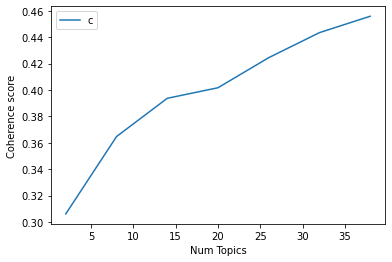

In [35]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3061
Num Topics = 8  has Coherence Value of 0.3647
Num Topics = 14  has Coherence Value of 0.3937
Num Topics = 20  has Coherence Value of 0.4017
Num Topics = 26  has Coherence Value of 0.4245
Num Topics = 32  has Coherence Value of 0.4434
Num Topics = 38  has Coherence Value of 0.4559


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [37]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.121*"vote" + 0.057*"bill" + 0.047*"state" + 0.032*"pass" + 0.032*"law" + '
  '0.030*"voting" + 0.027*"ballot" + 0.026*"sign" + 0.026*"relief" + '
  '0.025*"early"'),
 (1,
  '0.048*"support" + 0.041*"leader" + 0.032*"republican" + 0.031*"member" + '
  '0.029*"group" + 0.029*"effort" + 0.026*"honor" + 0.026*"protester" + '
  '0.024*"lawmaker" + 0.021*"begin"'),
 (2,
  '0.094*"year" + 0.055*"make" + 0.038*"record" + 0.035*"history" + '
  '0.028*"set" + 0.028*"return" + 0.027*"life" + 0.026*"break" + 0.023*"tax" + '
  '0.019*"sentence"'),
 (3,
  '0.249*"trump" + 0.045*"claim" + 0.038*"campaign" + 0.030*"sue" + '
  '0.029*"impeachment" + 0.028*"reject" + 0.024*"lawsuit" + 0.023*"make" + '
  '0.019*"lawyer" + 0.018*"false"'),
 (4,
  '0.092*"people" + 0.073*"trump" + 0.038*"coronavirus" + 0.036*"lose" + '
  '0.031*"urge" + 0.031*"case" + 0.027*"hold" + 0.027*"suspend" + 0.022*"send" '
  '+ 0.018*"twitter"'),
 (5,
  '0.045*"order" + 0.029*"fight" + 0.026*"court" + 0.025*"seek" + 0.02

Those were the topics for the chosen LDA model.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Finding the dominant topic in each sentence</h2>
</div>

Determine what topic a given document is about.

The topic number that has the highest percentage contribution in that document is what we call out here.

In [38]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.0789,"police, die, officer, family, fire, home, chie...",WATCH: 100 protesters show up at home of man w...
1,1,1.0,0.0660,"support, leader, republican, member, group, ef...",Kinzinger says he suspects some lawmakers knew...
2,2,11.0,0.0843,"call, official, trump, report, top, open, case...",Maricopa County official on rejecting Trump al...
3,3,10.0,0.0804,"woman, man, arrest, pay, turn, free, thousand,...",A man who went on a racist rant gave out his a...
4,4,5.0,0.0848,"order, fight, court, seek, end, nation, releas...",Surfside catastrophe raises concerns about San...
5,5,0.0,0.0500,"vote, bill, state, pass, law, voting, ballot, ...",Blake Shelton and Gwen Stefani are married
6,6,0.0,0.0500,"vote, bill, state, pass, law, voting, ballot, ...","Courteney Cox, Jennifer Aniston and Lisa Kudro..."
7,7,4.0,0.0639,"people, trump, coronavirus, lose, urge, case, ...",At least 150 people fatally shot in more than ...
8,8,13.0,0.0744,"black, trump, show, stop, video, give, campaig...",Vanessa Williams and PBS slammed for Black na...
9,9,11.0,0.0716,"call, official, trump, report, top, open, case...",Trump could be called to testify before House ...


The tabular output above had 20 rows, one each for a topic. It has the topic number, the keywords and the most representative document. The `Perc_Contribution` column is nothing but the percentage contribution of the topic in the given document.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Topic distribution across documents</h2>
</div>

In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"police, die, officer, family, fire, home, chie...",2588.0,0.1168
1.0,1.0,"support, leader, republican, member, group, ef...",1393.0,0.0628
2.0,11.0,"call, official, trump, report, top, open, case...",1312.0,0.0592
3.0,10.0,"woman, man, arrest, pay, turn, free, thousand,...",1072.0,0.0484
4.0,5.0,"order, fight, court, seek, end, nation, releas...",1157.0,0.0522
5.0,0.0,"vote, bill, state, pass, law, voting, ballot, ...",1069.0,0.0482
6.0,0.0,"vote, bill, state, pass, law, voting, ballot, ...",1098.0,0.0495
7.0,4.0,"people, trump, coronavirus, lose, urge, case, ...",1105.0,0.0499
8.0,13.0,"black, trump, show, stop, video, give, campaig...",1060.0,0.0478
9.0,11.0,"call, official, trump, report, top, open, case...",1105.0,0.0499
